# Assignment 1
## Shuai Shao

In [17]:
from feat import Detector
from feat.plotting import imshow
from IPython.display import Image
import pandas as pd
import cv2
from pathlib import Path
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv("../dataset/annotations.csv")
print(df)

                file   valence
0          thumbs-up  positive
1            sad-man  negative
2              claws  negative
3    laughing-couple  positive
4         by-the-sea  negative
5            arguing  negative
6   enjoying-the-sun  positive
7          piggyback  positive
8           back-off  negative
9          handshake  positive
10            tablet  negative
11         happy-man  positive
12         sad-woman  negative
13          business  positive
14              pain  negative
15          students  positive
16             bills  negative
17           bullied  negative
18      disagreement  negative
19      grandparents  positive


In [19]:
detector = Detector(face_model="retinaface", au_model = "xgb", emotion_model="resmasknet")

In [29]:
def proc_image(path, detector):

    pred = detector.detect_image(path)
    img = cv2.imread(path)
    #pred.plot_detections()


    fb = pred.faceboxes
    x_start = np.floor(fb['FaceRectX']).astype('int')
    y_start = np.floor(fb['FaceRectY']).astype('int')
    start_points = list(zip(x_start, y_start))
    end_points = list(zip((np.ceil(fb['FaceRectWidth']).astype('int')+x_start), (np.ceil(fb['FaceRectHeight']).astype('int')+y_start)))
    for start, end in zip(start_points, end_points):
        print(start)
        print(end)
        img = cv2.rectangle(img, start, end, color = (255, 0, 0), thickness = 3)

    # TODO implement emotion text annotation
    # em = pred.emotions
    # cv2.putText(image, )

    aus = pred.aus
    name = Path(path).stem
    aus['file'] = name
    aus['face'] = range(len(aus))
    

    cv2.imwrite(f"../processed/images/{name}.jpg", img)
    return aus

all_aus = reduce((lambda a, b: a.append(b)), list(map(lambda y: proc_image(y, detector), map(lambda x: f"../dataset/images/{x}.jpg", df['file']))))
all_aus.to_csv("../processed/aus.csv", index = False)
ann_aus = pd.merge(df, all_aus, on='file', how  = 'inner')
ann_aus.loc[ann_aus['valence'] = 'positive', '', '']
print(ann_aus)


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(578, 73)
(707, 255)


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(331, 328)
(426, 453)


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(418, 149)
(555, 353)


100%|██████████| 1/1 [00:03<00:00,  3.31s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(318, 373)
(521, 628)
(398, -2)
(541, 147)
(108, 307)
(303, 576)


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(144, 485)
(194, 541)
(453, 411)
(490, 469)


100%|██████████| 1/1 [00:03<00:00,  3.29s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(269, 143)
(422, 355)
(648, 224)
(730, 333)


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(504, 153)
(571, 237)


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(285, 206)
(409, 367)
(449, 129)
(540, 253)


100%|██████████| 1/1 [00:04<00:00,  4.41s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(492, 85)
(587, 211)


100%|██████████| 1/1 [00:04<00:00,  4.01s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(221, 189)
(288, 282)
(437, 124)
(523, 234)
(66, 138)
(143, 254)


100%|██████████| 1/1 [00:02<00:00,  2.74s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(608, 101)
(716, 256)


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(540, 114)
(673, 287)


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(433, 160)
(589, 353)


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(378, 402)
(523, 600)


100%|██████████| 1/1 [00:03<00:00,  3.02s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(421, 77)
(522, 187)


100%|██████████| 1/1 [00:04<00:00,  4.98s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(641, 198)
(694, 273)
(404, 210)
(454, 276)
(566, 106)
(613, 167)
(202, 77)
(245, 146)


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(177, 73)
(318, 248)


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(572, 139)
(797, 446)
(143, 405)
(230, 509)


100%|██████████| 1/1 [00:04<00:00,  4.82s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(664, 151)
(858, 399)
(448, 129)
(564, 285)
(183, 146)
(292, 284)


100%|██████████| 1/1 [00:04<00:00,  4.62s/it]
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['file'] = name
C:\Users\Shuai Shao\AppData\Local\Temp\ipykernel_2924\1233291829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['face'] = range(len(aus))


(457, 168)
(555, 295)
(354, 165)
(458, 304)
(560, 107)
(661, 239)
                file   valence      AU01      AU02      AU04      AU05  \
0          thumbs-up  positive  0.292465  0.432277  0.175178  0.229799   
1            sad-man  negative  0.652417  0.417060  0.224957  0.483308   
2              claws  negative  0.332971  0.105001  0.931827  0.298775   
3    laughing-couple  positive  0.518089  0.523467  0.454088  0.320439   
4    laughing-couple  positive  0.520513  0.187610  0.607923  0.309339   
5    laughing-couple  positive  0.711365  0.580891  0.488883  0.305874   
6         by-the-sea  negative  0.402138  0.205589  0.701418  0.257941   
7         by-the-sea  negative  0.680756  0.136374  0.665335  0.288808   
8            arguing  negative  0.151386  0.140141  0.354548  0.361352   
9            arguing  negative  0.389003  0.127074  0.843135  0.459386   
10  enjoying-the-sun  positive  0.421177  0.421142  0.206989  0.336657   
11         piggyback  positive  0.583144  0.16

(667, 1000, 3)


TypeError: unhashable type: 'numpy.ndarray'

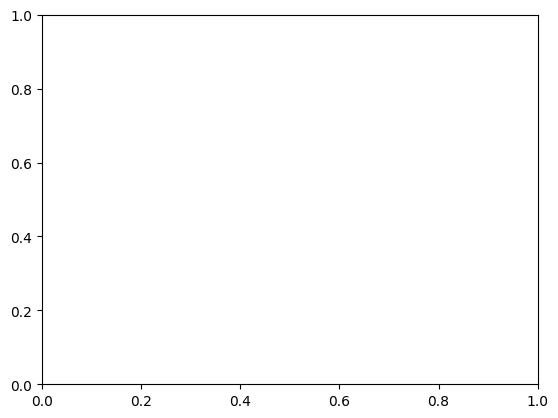

In [15]:

# img = cv2.imread('../dataset/images/arguing.jpg')
# print(img.shape)
# plt.imshow('test', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


## Reflections
### 1.


### 2.
* I would use backward feature elimination to determine which features yields the best performance increase / lowest performance decrease at the specified number of features. While it may be tempting to choose the AUs with the greatest mean difference between classes, these AUs may be intercorrelated, meaning that using more than one would may provide little to new information gain.
* Having too many features can be a problem as the solution space becomes much larger and requires more data in order to train the model, otherwise possibly leading to overfitting, known as the curse of dimensionality.